# Neural Networks Project

### The Problem Description

> Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street level photographs is Google’s Street View imagery comprised of hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents.


> More broadly, recognizing numbers in photographs is a problem of interest to the optical character recognition community. While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and character arrangements. The recognition problem is further complicated by environmental factors such as lighting, shadows, secularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs.

> In this project we will use dataset with images centred around a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simpler, it is more complex than MNIST because of the distractors.








### Data Description

**The Street View House Numbers (SVHN) **

> Dataset SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Link to the dataset: https://drive.google.com/file/d/1L2-WXzguhUsCArrFUc8EEkXcj33pahoS/view?usp=sharing





### Import the Required Libraries

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
# Metrics and preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the training, validation and test sets

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Colab Notebooks/Great Learning')

In [ ]:
# Read the h5 file
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')

# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

# Close this file

h5_SVH.close()

print('Training set', X_train.shape, y_train_o.shape)
print('Validation set', X_val.shape, y_val_o.shape)
print('Test set', X_test.shape, y_test_o.shape)

print('\n')
print('Unique labels in y_train:', np.unique(y_train_o))
print('Unique labels in y_val:', np.unique(y_val_o))
print('Unique labels in y_test:', np.unique(y_test_o))

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_val: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


### Visualizing first 10 images

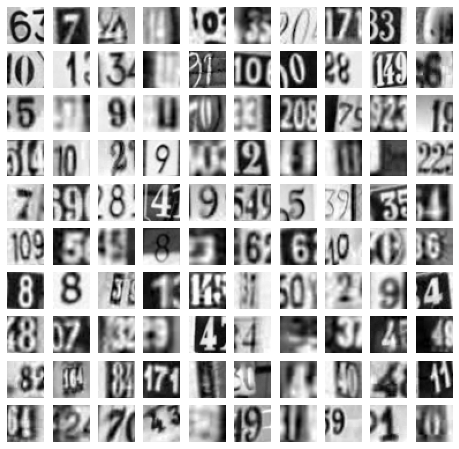

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

### Flatten and normalize the images for Keras

In [ ]:
print('Reshaping data')
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalize the inputs from 0-255 to 0-1')
X_train /= 255
X_val /= 255
X_test /= 255

print('Apply one-hot encoding')
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping data
Normalize the inputs from 0-255 to 0-1
Apply one-hot encoding


In [ ]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('\n')
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print('\n')
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_val', X_val.shape[0])
print('Number of images in X_test', X_test.shape[0])

X_train shape: (42000, 1024)
X_val shape: (60000, 1024)
X_test shape: (18000, 1024)


y_train shape: (42000, 10)
y_val shape: (60000, 10)
y_test shape: (18000, 10)


Number of images in X_train 42000
Number of images in X_val 60000
Number of images in X_test 18000


### Building Neural Networks with TensorFlow and Keras

In [ ]:
#Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
model = Sequential()

# Hidden layers
model.add(Dense(128, input_shape=(1024,),activation='relu',name='Layer_1'))
model.add(Dense(128,activation='relu',name='Layer_2'))
model.add(Dense(64,activation='relu',name='Layer_3'))

#Output layer
model.add(Dense(10,activation='softmax',name='Output'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
Layer_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
Layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Output (Dense)               (None, 10)                650       
Total params: 156,618
Trainable params: 156,618
Non-trainable params: 0
_________________________________________________________________


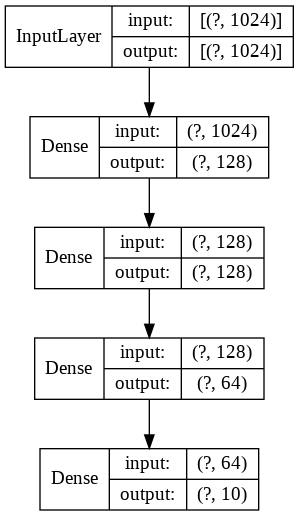

In [ ]:
plot_model(model, to_file='model_struct.png', show_shapes=True, show_layer_names=False)

In [ ]:
# compiling the neural network classifier, sgd optimizer
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 256, epochs = 100, verbose = 0)
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_val, y_val))

1313/1313 [==============================] - 3s 2ms/step - loss: 1.6193 - accuracy: 0.5669
[1.6192684173583984, 0.5669047832489014]
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6499 - accuracy: 0.5635
[1.6498867273330688, 0.5634833574295044]


In [ ]:
# compiling the neural network classifier, Adam optimizer
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 256, epochs = 100, verbose = 0)
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_val, y_val))

1313/1313 [==============================] - 3s 2ms/step - loss: 0.4340 - accuracy: 0.8589
[0.43404674530029297, 0.8588571548461914]
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5248 - accuracy: 0.8412
[0.5247967839241028, 0.8411666750907898]


### Tune the Training Optimization Algorithm

https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3

https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0

https://cs231n.github.io/neural-networks-3/

In [ ]:
def create_model1(optimizer='Adam'):

  #Clear out tensorflow memory
  tf.keras.backend.clear_session()

  # Initialize Sequential model
  model1 = Sequential()

  # Hidden layers
  model1.add(Dense(128, input_shape=(1024,),activation='relu',name='Layer_1'))
  model1.add(Dense(128,activation='relu',name='Layer_2'))
  model1.add(Dense(64,activation='relu',name='Layer_3'))

  #Output layer
  model1.add(Dense(10,activation='softmax',name='Output'))
  
  model1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model1

In [ ]:
# create model
KC_model = KerasClassifier(build_fn=create_model1, epochs=100, batch_size=256, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam', 'Nadam']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=KC_model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] optimizer=SGD ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... optimizer=SGD, total= 1.5min
[CV] optimizer=SGD ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] .................................... optimizer=SGD, total= 1.5min
[CV] optimizer=SGD ...................................................
[CV] .................................... optimizer=SGD, total= 1.5min
[CV] optimizer=RMSprop ...............................................
[CV] ................................ optimizer=RMSprop, total= 1.8min
[CV] optimizer=RMSprop ...............................................
[CV] ................................ optimizer=RMSprop, total= 1.8min
[CV] optimizer=RMSprop ...............................................
[CV] ................................ optimizer=RMSprop, total= 1.8min
[CV] optimizer=Adam ..................................................
[CV] ................................... optimizer=Adam, total= 1.6min
[CV] optimizer=Adam ..................................................
[CV] ................................... optimizer=Adam, total= 1.6min
[CV] optimizer=Adam ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 21.0min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.722933 using {'optimizer': 'Adam'}
0.577833 (0.099845) with: {'optimizer': 'SGD'}
0.678933 (0.095009) with: {'optimizer': 'RMSprop'}
0.722933 (0.091156) with: {'optimizer': 'Adam'}
0.697433 (0.106797) with: {'optimizer': 'Nadam'}


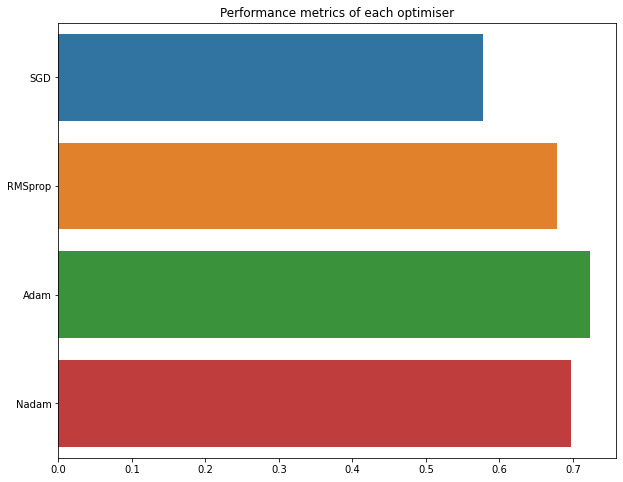

In [ ]:
plt.figure(figsize=(10,8))
#pyplot.xticks(grid_result1.cv_results_['mean_test_score'])
plt.title("Performance metrics of each optimiser")
plot=sns.barplot(grid_result.cv_results_['mean_test_score'],optimizer)
plt.show() 

### Tune Network Weight Initialization

In [ ]:
def create_model2(init_mode='uniform',optimizer='Adam'):

  #Clear out tensorflow memory
  tf.keras.backend.clear_session()

  # Initialize Sequential model
  model2 = Sequential()

  # Hidden layers
  model2.add(Dense(128, input_shape=(1024,), kernel_initializer=init_mode, activation='relu', name='Layer_1'))
  model2.add(Dense(128, kernel_initializer=init_mode, activation='relu', name='Layer_2'))
  model2.add(Dense(64, kernel_initializer=init_mode, activation='relu', name='Layer_3'))

  #Output layer
  model2.add(Dense(10,activation='softmax',name='Output'))
  
  model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model2

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model2, epochs=100, batch_size=256, verbose=0)
# define the grid search parameters
optimizer = ['Adam','SGD']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode,optimizer=optimizer)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=1, cv=3, verbose=2, n_iter=10)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=Adam, init_mode=normal ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. optimizer=Adam, init_mode=normal, total= 1.7min
[CV] optimizer=Adam, init_mode=normal ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ................. optimizer=Adam, init_mode=normal, total= 1.7min
[CV] optimizer=Adam, init_mode=normal ................................
[CV] ................. optimizer=Adam, init_mode=normal, total= 1.7min
[CV] optimizer=SGD, init_mode=normal .................................
[CV] .................. optimizer=SGD, init_mode=normal, total= 1.6min
[CV] optimizer=SGD, init_mode=normal .................................
[CV] .................. optimizer=SGD, init_mode=normal, total= 1.6min
[CV] optimizer=SGD, init_mode=normal .................................
[CV] .................. optimizer=SGD, init_mode=normal, total= 1.6min
[CV] optimizer=SGD, init_mode=lecun_uniform ..........................
[CV] ........... optimizer=SGD, init_mode=lecun_uniform, total= 1.6min
[CV] optimizer=SGD, init_mode=lecun_uniform ..........................
[CV] ........... optimizer=SGD, init_mode=lecun_uniform, total= 1.5min
[CV] optimizer=SGD, init_mode=lecun_uniform ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 49.1min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.722850 using {'optimizer': 'Adam', 'init_mode': 'he_uniform'}
0.712967 (0.089722) with: {'optimizer': 'Adam', 'init_mode': 'normal'}
0.546200 (0.104243) with: {'optimizer': 'SGD', 'init_mode': 'normal'}
0.592683 (0.105092) with: {'optimizer': 'SGD', 'init_mode': 'lecun_uniform'}
0.033333 (0.047140) with: {'optimizer': 'SGD', 'init_mode': 'zero'}
0.721217 (0.089272) with: {'optimizer': 'Adam', 'init_mode': 'he_normal'}
0.689483 (0.081041) with: {'optimizer': 'Adam', 'init_mode': 'uniform'}
0.577367 (0.134824) with: {'optimizer': 'SGD', 'init_mode': 'glorot_normal'}
0.033333 (0.047140) with: {'optimizer': 'Adam', 'init_mode': 'zero'}
0.633000 (0.107751) with: {'optimizer': 'SGD', 'init_mode': 'glorot_uniform'}
0.722850 (0.091708) with: {'optimizer': 'Adam', 'init_mode': 'he_uniform'}


### Tune Learning Rate and Momentum

In [ ]:
def create_model3(learn_rate=0.01, momentum=0):

  #Clear out tensorflow memory
  tf.keras.backend.clear_session()

  # Initialize Sequential model
  model3 = Sequential()

  # Hidden layers
  model3.add(Dense(128, input_shape=(1024,),activation='relu',name='Layer_1'))
  model3.add(Dense(128,activation='relu',name='Layer_2'))
  model3.add(Dense(64,activation='relu',name='Layer_3'))

  #Output layer
  model3.add(Dense(10,activation='softmax',name='Output'))

  optimizer = SGD(lr=learn_rate, momentum=momentum)

  model3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model3

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model3, epochs=100, batch_size=256, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=1, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] momentum=0.2, learn_rate=0.001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... momentum=0.2, learn_rate=0.001, total= 1.7min
[CV] momentum=0.2, learn_rate=0.001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ................... momentum=0.2, learn_rate=0.001, total= 1.6min
[CV] momentum=0.2, learn_rate=0.001 ..................................
[CV] ................... momentum=0.2, learn_rate=0.001, total= 1.6min
[CV] momentum=0.6, learn_rate=0.001 ..................................
[CV] ................... momentum=0.6, learn_rate=0.001, total= 1.6min
[CV] momentum=0.6, learn_rate=0.001 ..................................
[CV] ................... momentum=0.6, learn_rate=0.001, total= 1.6min
[CV] momentum=0.6, learn_rate=0.001 ..................................
[CV] ................... momentum=0.6, learn_rate=0.001, total= 1.6min
[CV] momentum=0.6, learn_rate=0.2 ....................................
[CV] ..................... momentum=0.6, learn_rate=0.2, total= 1.7min
[CV] momentum=0.6, learn_rate=0.2 ....................................
[CV] ..................... momentum=0.6, learn_rate=0.2, total= 1.6min
[CV] momentum=0.6, learn_rate=0.2 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 49.0min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.740800 using {'momentum': 0.9, 'learn_rate': 0.01}
0.118400 (0.166524) with: {'momentum': 0.2, 'learn_rate': 0.001}
0.317933 (0.193680) with: {'momentum': 0.6, 'learn_rate': 0.001}
0.033333 (0.047140) with: {'momentum': 0.6, 'learn_rate': 0.2}
0.647883 (0.113514) with: {'momentum': 0.2, 'learn_rate': 0.01}
0.637917 (0.096578) with: {'momentum': 0.0, 'learn_rate': 0.3}
0.698217 (0.083774) with: {'momentum': 0.0, 'learn_rate': 0.1}
0.597217 (0.123308) with: {'momentum': 0.0, 'learn_rate': 0.01}
0.740800 (0.089452) with: {'momentum': 0.9, 'learn_rate': 0.01}
0.033900 (0.046745) with: {'momentum': 0.9, 'learn_rate': 0.2}
0.682617 (0.109815) with: {'momentum': 0.6, 'learn_rate': 0.1}


### Batch Normalization

In [ ]:
#Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
model4 = Sequential()

# Hidden layers
model4.add(Dense(128, input_shape = (1024, ), kernel_initializer = 'he_uniform'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
# Adding activation function
model4.add(Activation('relu'))

model4.add(Dense(128, kernel_initializer = 'he_uniform'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
# Adding activation function
model4.add(Activation('relu'))

model4.add(Dense(64, kernel_initializer = 'he_uniform'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
#Adding activation function
model4.add(Activation('relu'))

#Output layer
model4.add(Dense(10,activation='softmax'))

In [ ]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr=0.1, momentum=0.6)
# Adding activation function - softmax for multiclass classification
model4.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, verbose = 2)
print(model4.evaluate(X_train, y_train))
print(model4.evaluate(X_val, y_val))

Epoch 1/100
657/657 - 5s - loss: 1.7370 - accuracy: 0.3895 - val_loss: 1.7892 - val_accuracy: 0.3807
Epoch 2/100
657/657 - 4s - loss: 1.2856 - accuracy: 0.5790 - val_loss: 1.3484 - val_accuracy: 0.5607
Epoch 3/100
657/657 - 4s - loss: 1.1381 - accuracy: 0.6347 - val_loss: 1.2786 - val_accuracy: 0.5727
Epoch 4/100
657/657 - 5s - loss: 1.0550 - accuracy: 0.6655 - val_loss: 1.1648 - val_accuracy: 0.6108
Epoch 5/100
657/657 - 4s - loss: 0.9891 - accuracy: 0.6848 - val_loss: 1.3325 - val_accuracy: 0.5437
Epoch 6/100
657/657 - 4s - loss: 0.9500 - accuracy: 0.6958 - val_loss: 1.1676 - val_accuracy: 0.6053
Epoch 7/100
657/657 - 5s - loss: 0.9163 - accuracy: 0.7112 - val_loss: 1.0103 - val_accuracy: 0.6835
Epoch 8/100
657/657 - 5s - loss: 0.8890 - accuracy: 0.7201 - val_loss: 1.7383 - val_accuracy: 0.4463
Epoch 9/100
657/657 - 4s - loss: 0.8640 - accuracy: 0.7282 - val_loss: 1.2738 - val_accuracy: 0.6187
Epoch 10/100
657/657 - 4s - loss: 0.8450 - accuracy: 0.7338 - val_loss: 1.0208 - val_accura

### Final Model after Tuning

In [ ]:
#Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
model4 = Sequential()

# Hidden layers
model4.add(Dense(128, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
# Adding activation function
model4.add(Activation('relu'))

model4.add(Dense(128, kernel_initializer = 'he_normal'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
# Adding activation function
model4.add(Activation('relu'))

model4.add(Dense(64, kernel_initializer = 'he_normal'))
# Adding batch normalization
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
#Adding activation function
model4.add(Activation('relu'))

#Output layer
model4.add(Dense(10,activation='softmax'))
model4.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, verbose = 2)
print(model4.evaluate(X_train, y_train))
print(model4.evaluate(X_val, y_val))

Epoch 1/100
657/657 - 4s - loss: 1.8166 - accuracy: 0.3691 - val_loss: 1.4848 - val_accuracy: 0.5101
Epoch 2/100
657/657 - 4s - loss: 1.2965 - accuracy: 0.5777 - val_loss: 1.3387 - val_accuracy: 0.5532
Epoch 3/100
657/657 - 4s - loss: 1.1493 - accuracy: 0.6316 - val_loss: 1.2557 - val_accuracy: 0.5833
Epoch 4/100
657/657 - 4s - loss: 1.0578 - accuracy: 0.6641 - val_loss: 1.0865 - val_accuracy: 0.6553
Epoch 5/100
657/657 - 4s - loss: 0.9927 - accuracy: 0.6869 - val_loss: 1.1152 - val_accuracy: 0.6287
Epoch 6/100
657/657 - 5s - loss: 0.9382 - accuracy: 0.7023 - val_loss: 1.1263 - val_accuracy: 0.6205
Epoch 7/100
657/657 - 4s - loss: 0.9057 - accuracy: 0.7145 - val_loss: 0.9456 - val_accuracy: 0.6930
Epoch 8/100
657/657 - 5s - loss: 0.8746 - accuracy: 0.7244 - val_loss: 1.0616 - val_accuracy: 0.6554
Epoch 9/100
657/657 - 4s - loss: 0.8495 - accuracy: 0.7333 - val_loss: 0.9546 - val_accuracy: 0.6862
Epoch 10/100
657/657 - 4s - loss: 0.8237 - accuracy: 0.7392 - val_loss: 1.0446 - val_accura

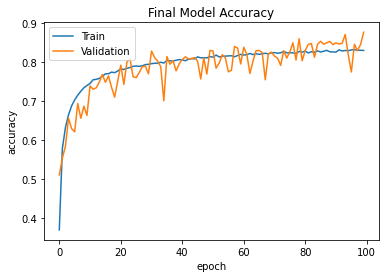

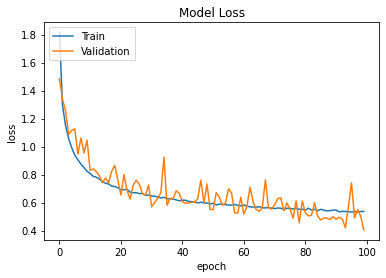

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [ ]:
print('Testing the model on test dataset')
predictions = model4.predict_classes(X_test)
score = model4.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Testing the model on test dataset
563/563 [==============================] - 1s 2ms/step - loss: 0.5102 - accuracy: 0.8449
Test loss : 0.510240912437439
Test accuracy : 0.844944417476654


In [ ]:
print('Classification Report')
print(classification_report(y_test_o, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1814
           1       0.77      0.90      0.83      1828
           2       0.92      0.83      0.87      1803
           3       0.81      0.80      0.80      1719
           4       0.80      0.92      0.85      1812
           5       0.77      0.88      0.82      1768
           6       0.86      0.83      0.84      1832
           7       0.90      0.87      0.88      1808
           8       0.85      0.81      0.82      1812
           9       0.89      0.81      0.85      1804

    accuracy                           0.84     18000
   macro avg       0.85      0.84      0.85     18000
weighted avg       0.85      0.84      0.85     18000



Visualizing the confusion matrix


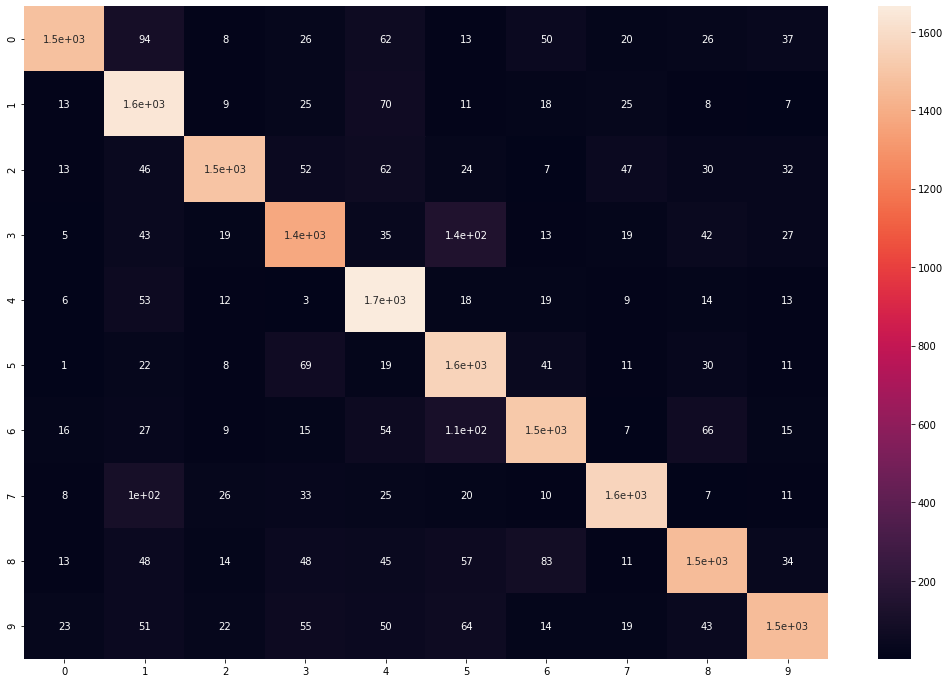

In [ ]:
print('Visualizing the confusion matrix')
plt.figure(figsize = (18, 12))
sns.heatmap(confusion_matrix(y_test_o, predictions), annot = True)